# AI_campus_ProstateSeg 
# Module 11: Image Segmentation Using U-Net Prototype
### PANDA: Prostate cANcer graDe Assessment (PANDA) Challenge

In this module, we will develop a basic U-Net model using convolutional layers in order to obtain segmentation results for the images. Unlike the previous module where we used a MLP softmax classifier to segment the images by predicting the distribution of classes for each pixel of the image, in this approach we will develop a U-Net model, which uses convolutional layers, in order to predict a segmentation mask. Unlike the MLP classifier, the images will be fed in a tile-wise manner in case of this model. These tiles will be non-overlapping in nature, and will be selected based on a certain signal to noise ratio (where signal is indicated by pixels that contain a value of more than 0, i.e. areas which contain tissue characterized by a category of disease progression). This type of a model is considerate of the spatial relationships and spatial distribution of the pixels in an image, effectively treating each pixel in context of its neighboring pixels, making it position sensitive. This contributes to the predictive process because images tend to exhibit a lot of spatial redundancy, where neighboring pixels tend to be related to each other. 

### 1. Import the necessary packages

In [2]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import panda_utils as putil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2

from PIL import Image
from typing import List, Set, Union, Optional, Dict, Tuple
from torch.utils.data import Dataset, DataLoader
from dataclass import ToyPANDASDataset
from torchvision.transforms import functional as Fv
from scipy.stats import entropy
from normalizers import ChannelWiseMinMaxNormalizer
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler

### 2. Define folder and subdirectory folder names for training and testing image-mask pairs

In [3]:
# Define root folder
ROOT_FOLDER = "sample_data"

# Define training data folders for images and masks
TRAIN_IMAGE_SUBFOLDER = "train_images"
TRAIN_MASK_SUBFOLDER = "train_label_masks"

# Define test data folders for images and masks
TEST_IMAGE_SUBFOLDER = "test_images"
TEST_MASK_SUBFOLDER = "test_label_masks"

# Define train image and mask directory paths
train_image_dir = os.path.join(ROOT_FOLDER, TRAIN_IMAGE_SUBFOLDER)
train_mask_dir = os.path.join(ROOT_FOLDER, TRAIN_MASK_SUBFOLDER)

# Define test image and mask directory paths
test_image_dir = os.path.join(ROOT_FOLDER, TEST_IMAGE_SUBFOLDER)
test_mask_dir = os.path.join(ROOT_FOLDER, TEST_MASK_SUBFOLDER)

### 3. Create list of image and mask files and print contents for both the training and test set data

In [4]:
train_image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(train_image_dir))))
train_mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(train_mask_dir))))

test_image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(test_image_dir))))
test_mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(test_mask_dir))))

Print list of training set image files

In [5]:
train_image_files

['0018ae58b01bdadc8e347995b69f99aa.tiff',
 '004dd32d9cd167d9cc31c13b704498af.tiff',
 '0068d4c7529e34fd4c9da863ce01a161.tiff',
 '006f6aa35a78965c92fffd1fbd53a058.tiff',
 '007433133235efc27a39f11df6940829.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a.tiff',
 '008069b542b0439ed69b194674051964.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff',
 '00951a7fad040bf7e90f32e81fc0746f.tiff',
 '00a26aaa82c959624d90dfb69fcf259c.tiff']

Print list of training set mask files. Each of these will have a "_mask.tiff" extension.

In [6]:
train_mask_files

['0018ae58b01bdadc8e347995b69f99aa_mask.tiff',
 '004dd32d9cd167d9cc31c13b704498af_mask.tiff',
 '0068d4c7529e34fd4c9da863ce01a161_mask.tiff',
 '006f6aa35a78965c92fffd1fbd53a058_mask.tiff',
 '007433133235efc27a39f11df6940829_mask.tiff',
 '0076bcb66e46fb485f5ba432b9a1fe8a_mask.tiff',
 '008069b542b0439ed69b194674051964_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff',
 '00951a7fad040bf7e90f32e81fc0746f_mask.tiff',
 '00a26aaa82c959624d90dfb69fcf259c_mask.tiff']

Print list of test set image files

In [7]:
test_image_files

['00a7fb880dc12c5de82df39b30533da9.tiff',
 '00bbc1482301d16de3ff63238cfd0b34.tiff',
 '00c15b23b30a5ba061358d9641118904.tiff',
 '00c46b336b5b06423fcdec1b4d5bee06.tiff',
 '00c52cb4db1c7a5811a8f070a910c038.tiff']

Print list of test set mask files. Each of these will have a "_mask.tiff" extension.

In [8]:
test_mask_files

['00a7fb880dc12c5de82df39b30533da9_mask.tiff',
 '00bbc1482301d16de3ff63238cfd0b34_mask.tiff',
 '00c15b23b30a5ba061358d9641118904_mask.tiff',
 '00c46b336b5b06423fcdec1b4d5bee06_mask.tiff',
 '00c52cb4db1c7a5811a8f070a910c038_mask.tiff']

### 4. Run function from module 1 to verify pair match, such that each image is coupled with a mask file for both the training and test set data

Verify pair match for training image and mask files

In [9]:
putil.verify_pair_match(image_dir = train_image_dir,
                        mask_dir = train_mask_dir)

True

Verify pair match for testing image and mask files

In [10]:
putil.verify_pair_match(image_dir = test_image_dir,
                        mask_dir = test_mask_dir)

True

### 5. Run function from module 1 to verify dimensionality match between image and mask files

Verify dimensionality match for training set image and mask files

In [11]:
putil.verify_dim_match(image_dir = train_image_dir,
                       mask_dir = train_mask_dir,
                       root_folder = ROOT_FOLDER,
                       image_subfolder = TRAIN_IMAGE_SUBFOLDER,
                       mask_subfolder = TRAIN_MASK_SUBFOLDER)

True

Verify dimensionality match for testing set image and mask files

In [12]:
putil.verify_dim_match(image_dir = test_image_dir,
                       mask_dir = test_mask_dir,
                       root_folder = ROOT_FOLDER,
                       image_subfolder = TEST_IMAGE_SUBFOLDER,
                       mask_subfolder = TEST_MASK_SUBFOLDER)

True

### 6. Run function from module 1 to validate the mask directory for both the training set and test set image data

Validate the training set mask files

In [13]:
putil.validate_mask_dir(mask_dir = train_mask_dir,
                        root_folder = ROOT_FOLDER,
                        mask_subfolder = TRAIN_MASK_SUBFOLDER)

True

Validate the test set mask files

In [14]:
putil.validate_mask_dir(mask_dir = test_mask_dir,
                        root_folder = ROOT_FOLDER,
                        mask_subfolder = TEST_MASK_SUBFOLDER)

True

### 7. Load and print the dimensionalities of the images and masks from the training and testing sets

Print the dimensionalities of the image files in the training set

In [15]:
for image_file in train_image_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TRAIN_IMAGE_SUBFOLDER, image_file))
    print(img.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


Print the dimensionalities of the mask files in the training set

In [16]:
for image_file in train_mask_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TRAIN_MASK_SUBFOLDER, image_file))
    print(img.shape)

(25344, 5888, 3)
(22528, 8192, 3)
(10496, 6912, 3)
(7680, 2048, 3)
(24320, 9472, 3)
(14848, 11776, 3)
(8704, 23808, 3)
(36352, 10752, 3)
(8192, 11520, 3)
(20736, 18688, 3)


Print the dimensionalities of the image files in the testing set

In [17]:
for image_file in test_image_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TEST_IMAGE_SUBFOLDER, image_file))
    print(img.shape)

(4352, 32256, 3)
(26624, 5120, 3)
(36352, 8704, 3)
(31744, 4096, 3)
(23296, 9984, 3)


Print the dimensionalities of the mask files in the testing set

In [18]:
for image_file in test_mask_files:
    img = tifffile.imread(os.path.join(ROOT_FOLDER, TEST_MASK_SUBFOLDER, image_file))
    print(img.shape)

(4352, 32256, 3)
(26624, 5120, 3)
(36352, 8704, 3)
(31744, 4096, 3)
(23296, 9984, 3)


### 8. Re-write dataset class to load both images and masks in a tile by tile manner

The initial dataset class written in the fourth module did not return masks. Since we are setting up a pipeline for supervised machine learning, we will write another class that iterates over the images in a tile by tile manner and returns the tile alongside its corresponding mask

In [19]:
class ToyPANDASDataset(Dataset):
    
    def __init__(self,
                 image_dir: str,
                 mask_dir: str, 
                 root_dir: str,
                 mask_suffix: str = "_mask",
                 imfile_ext: str = ".tiff",
                 maskfile_ext: str = ".tiff",
                 tile_size: int = 224,
                 channel_idx: int = 0,
                 min_thresh: float = 0.5,
                 transform = None,
                 norm_func = None):
        
        """
        Dataset class for Toy PANDA dataset of 10 images and masks.
        
        Parameters
        -----------
        image_dir: str
            The directory containing the images. 
        
        mask_dir: str
            The directory containing the masks paired with each of the images. 
        
        root_dir: str
            The root directory containing both the image and mask folders.
        
        mask_suffix: str
            The suffix associated with mask files in the folder. In this case,
            it is "_mask." Each image is labeled alphanumerically, and its corresponding
            mask file has a "_mask" suffix following the alphanumeric name. 
        
        imfile_ext: str
            The extension or file type of the image file. In this case, it is ".tiff"
            
        maskfile_ext: str
            The extension or file type of the mask file. In this case, it is ".tiff"
        
        tile_size: int
            The size of the square tiles to extract from images in a non-overlapping way.
            Each tile extarcted from the image will contain (tile_size ** 2) number of pixels.
        
        channel_idx: int
            Since the masks in this PANDA dataset contain 3 channels. This constant indicates
            the location of the official, 2 by 2 mask in the 3 channel mask tensor. Default
            value is 0. 
        
        min_thresh: float
            This constant sets a criteria for tile qualification. A tile is only qualified to
            be positively filtered for the dataset if it containts signal (% of foreground of all pixels)
            that is more than or equal to min_thresh.
        
        transform: Optional[None, function]
            This object stores None or a function. If it is a function, this function is applied
            to the data before being returned by the get item dunder method. This transform could
            contain a normalization function or it could contain a series of augmentation steps
            applied before returning an image. 
        
        norm_func: Optional[None, function]
            Function to normalize a tile depending on certain pre-defined 
            min-max statistics (for min max normalization) or z-score normalization
            depending on pre-defined statistics for the mean and standard deviation. 
        
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.root_dir = root_dir
        self.mask_suffix = mask_suffix
        self.imfile_ext = imfile_ext
        self.maskfile_ext = maskfile_ext
        self.transform = transform
        self.norm_func = norm_func
        self.tile_size = tile_size
        self.full_mask_ext = self.mask_suffix + self.maskfile_ext
        self.channel_idx = channel_idx
        self.image_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.image_dir))))
        self.mask_files = list(filter(lambda file: file != '.DS_Store', sorted(os.listdir(self.mask_dir))))
        self.n_tiles_processed = 0
        self.n_qualifying_tiles = 0
        self.min_thresh = min_thresh
        self.imtile_coords = self.get_imtile_coords()
        
    def extract_raw_regid(self,
                          filename: str,
                          ext: str) -> str:
        """
        This function receives a filename which a specific
        extension like "_mask.tiff" or ".tiff", then it processes
        and returns the part of the filename up until but excluding
        the extension. 
        
        Parameters
        -----------
        filename: str
            The filename, with the name and extension as a suffix
        
        ext: str
            The extension
        
        Returns
        ----------
        The filename up until but excluding the extension
        
        """
        i = 1
        while filename[-i:] != ext:
            i += 1
        return filename[0:len(filename)-i]
    
    def tile_qualifier(self,
                       tile_mask: np.ndarray):
        """
        A tile qualifier function. This function
        receives a mask extracted from a tile. The mask
        can be binary or it could be multi-class,
        representing presence of multiple different classes
        indicated by integer values greater than or equal to 1. 
        The background (non-signal) region should be represented
        by 0. This function checks if the mask contains a minimum
        threshold of signal, as represented by the number of non-zero
        values as a percentage of the total number of pixels in the
        tile. 
        
        Parameters
        -----------
        tile_mask: np.ndarray
            A tile (square or rectangular) as a numpy array,
            containing integer values greater than or equal to 0.
        
        Returns
        ---------
        bool
            Whether the tile qualifies or not.
            Whether its signal ratio meets the minimum
            threshold requirement for it to qualify
            to be included in the dataset. 
            
        """
        
        signal_ratio = (tile_mask > 0).sum()/tile_mask.size
        
        return signal_ratio >= self.min_thresh
    
    def extract_nonoverlapping_tile_coords(self,
                                           mask: np.ndarray):
        
        """
        This function extracts nonoverlapping tile coordinates
        from a mask according to the tile_size. It collects
        the coordinates of the top left corner of each tile and 
        then returns it. 
        
        Paramters
        ---------
        mask: np.ndarray
            A mask of arbitrary shape. Containing 3 or more
            channels, but only the 0th channel is used as the
            official, signal indicating channel for extracting 
            tile coordinates.
        
        Returns
        --------
        List[Tuple[int, int]]
            A list of coordinates stored in tuples of size 2.
            These are coordinates of tiles that qualify according
            to the tile qualifier function. 
        """
        
        mask = mask[:,:,self.channel_idx]
        assert len(mask.shape) == 2
        R, C = mask.shape
        tile_coords = []
        for i in range(0, R, self.tile_size):
            for j in range(0, C, self.tile_size):
                try:
                    tile = mask[i : i + self.tile_size, j : j + self.tile_size]
                    self.n_tiles_processed += 1
                    if tile.shape == (self.tile_size, self.tile_size) and self.tile_qualifier(tile):
                        tile_coords.append((i, j))
                        self.n_qualifying_tiles += 1
                except IndexError:
                    print(f"Skipping tile at position ({i}, {j}) because it is out of bounds.")
                        
        return tile_coords
    
    def get_imtile_coords(self):
        
        """
        Function to process the images and return a list of 
        3-sized tuples that contain the name of the image file
        along with coordinates of qualifying tiles in them.
        The image file names can be repeated in tuples, but not
        the coordinate of the tiles.
        
        Parameters
        -----------
        None, all objects used are instantiated in the constructor.
        
        Returns
        -----------
        List[Tuple[str, in, int]]
            A list of tuples. The first value in the tuple is
            the name of the image file. The second and third
            values in the tuples are coordinates of one of the
            qualifying tiles in the image.
            
        """
        
        imtile_coords = []
        
        for imfile in self.image_files:
            regid = self.extract_raw_regid(imfile, self.imfile_ext)
            mask_file = regid + self.full_mask_ext
            mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
            tile_coords = self.extract_nonoverlapping_tile_coords(mask)
            imtile_coord = list(map(lambda tup : (imfile,) + tup, tile_coords))
            imtile_coords.extend(imtile_coord)
            
        self.tile_qualifying_ratio = self.n_qualifying_tiles / self.n_tiles_processed
        print(f"Total number of tiles processed: {self.n_tiles_processed}")
        print(f"Tile qualifying ratio: {round(self.tile_qualifying_ratio,2)}")
        print(f"Average number of tiles processed per image or mask: {self.n_tiles_processed/len(self.image_files)}")
        print(f"Average number of tiles qualifying per image or mask: {self.n_qualifying_tiles/len(self.image_files)}")
        
        imfiles = set([t[0] for t in imtile_coords])
        assert imfiles == set(self.image_files)
        i_vals = sorted(list(set([t[1] for t in imtile_coords])))
        j_vals = sorted(list(set([t[2] for t in imtile_coords])))
        
        for i in range(len(i_vals)-1):
            assert i_vals[i + 1] - i_vals[i] == self.tile_size
        
        for j in range(len(j_vals)-1):
            assert j_vals[j + 1] - j_vals[j] == self.tile_size
            
        return imtile_coords
        
    def __len__(self):
        
        """
        Dunder method to return the length of the
        dataset. The total length of the dataset 
        is the total number of tiles over all 
        of the images. Some images may provide more
        tiles to the dataset depending on their signal
        content, while other images may provide less
        tiles if they are weak in signal.
        """
        
        return len(self.imtile_coords)
    
    def __getitem__(self, idx):
        
        """
        Function for getting a tile from the dataset.
        Given an index, it finds a tuple in the imtile_coords
        and unpacks it to retrieve the image file and the coordinates
        of one of the qualifying tiles in the image. 
        """
        
        image_file, tile_i, tile_j = self.imtile_coords[idx]
        image = tifffile.imread(os.path.join(self.image_dir, image_file))
        tile = image[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size, :]
        regid = self.extract_raw_regid(image_file, self.imfile_ext)
        mask_file = regid + self.full_mask_ext
        mask = tifffile.imread(os.path.join(self.mask_dir, mask_file))
        mask = mask[:,:,self.channel_idx]
        tile_mask = mask[tile_i: tile_i + self.tile_size, tile_j: tile_j + self.tile_size]
        
        if self.transform:
            tile = self.transform(tile)
        
        if self.norm_func:
            tile = torch.tensor(tile)
            tile = tile.unsqueeze(0).permute(0, 3, 1, 2)
            tile = self.norm_func(tile)
            tile = tile.squeeze(0).permute(1,2,0)
            
        return tile, tile_mask

In [20]:
min_vals = torch.tensor([0, 0, 0])
max_vals = torch.tensor([255, 255, 255])

normalizer = ChannelWiseMinMaxNormalizer(min_values = min_vals,
                                         max_values = max_vals)

We have the following directories available for training and testing image and mask files:

- train_image_dir
- train_mask_dir

- test_image_dir
- test_mask_dir

### 9. Instantiate a DataLoader and start an iterator over the batch. While instantiating the DataLoader, pass the normalizer's transform function into the Dataset class

In [249]:
train_dataset = ToyPANDASDataset(image_dir = train_image_dir,
                                 mask_dir = train_mask_dir,
                                 root_dir = ROOT_FOLDER,
                                 norm_func = normalizer.transform,
                                 min_thresh = 0.5)

print("\n")

test_dataset = ToyPANDASDataset(image_dir = test_image_dir,
                                mask_dir = test_mask_dir,
                                root_dir = ROOT_FOLDER,
                                norm_func = normalizer.transform,
                                min_thresh = 0.5)

test_dataset_raw = ToyPANDASDataset(image_dir = test_image_dir,
                                    mask_dir = test_mask_dir,
                                    root_dir = ROOT_FOLDER,
                                    min_thresh = 0.5)

Total number of tiles processed: 38593
Tile qualifying ratio: 0.15
Average number of tiles processed per image or mask: 3859.3
Average number of tiles qualifying per image or mask: 596.6


Total number of tiles processed: 19352
Tile qualifying ratio: 0.23
Average number of tiles processed per image or mask: 3870.4
Average number of tiles qualifying per image or mask: 873.8
Total number of tiles processed: 19352
Tile qualifying ratio: 0.23
Average number of tiles processed per image or mask: 3870.4
Average number of tiles qualifying per image or mask: 873.8


Print the lengths of the training and testing datasets. This will return the number of tile and mask pairs available in the dataset. 

In [250]:
print(f"Length of the training dataset: {len(train_dataset)}")

Length of the training dataset: 5966


In [251]:
print(f"Length of the testing dataset: {len(test_dataset)}")

Length of the testing dataset: 4369


In order to perform a sanity check and verify the functionalities of the dataset and data loader classes, we will start an iterator over the training and testing datasets using a data loader.

In [256]:
train_loader = DataLoader(train_dataset, batch_size = 24, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 24, shuffle = False)
test_loader_raw = DataLoader(test_dataset_raw, batch_size = 24, shuffle = False)

Print the lengths of the train and test loaders, this will return the total number of batches present in the training and test loaders

In [257]:
print(f"Number of batches present in the train_loader: {len(train_loader)}")
print(f"Number of batches present in the test_loader: {len(test_loader)}")

Number of batches present in the train_loader: 249
Number of batches present in the test_loader: 183


Start an iterator over the training and testing loaders

In [258]:
train_iter = iter(train_loader)
test_iter = iter(test_loader)
test_iter_raw = iter(test_loader_raw)

Obtain a batch for the train loader

In [259]:
train_images, train_masks = next(train_iter)

Print the shape of the training images batch

In [260]:
train_images.shape

torch.Size([24, 224, 224, 3])

Print the shape of the training masks batch

In [261]:
train_masks.shape

torch.Size([24, 224, 224])

Plot the first tile from the training image batch

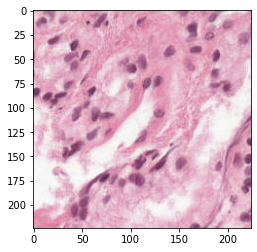

In [262]:
plt.imshow(train_images[0])

Enlist class presence in the first tile mask

In [263]:
putil.enlist_class_presence(train_masks[0])

array([0, 1], dtype=uint8)

Summarize the distribution of classes in the first train mask

In [264]:
putil.summarize_class_distribution(train_masks[0].numpy())

{0: 0.41, 1: 0.59}

Plot the last tile from the training image batch

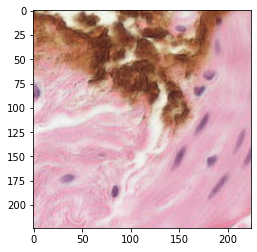

In [265]:
plt.imshow(train_images[-1])

Enlist class presence in the last tile mask

In [266]:
putil.enlist_class_presence(train_masks[-1])

array([1], dtype=uint8)

Summarize the distribution of classes in the last train mask

In [267]:
putil.summarize_class_distribution(train_masks[-1].numpy())

{1: 1.0}

Obtain a batch for the test loader

In [268]:
test_images, test_masks = next(test_iter)

Print the shape of the test image batch

In [269]:
test_images.shape

torch.Size([24, 224, 224, 3])

Print the shape of the test mask batch

In [270]:
test_masks.shape

torch.Size([24, 224, 224])

Plot the first tile from the test image batch

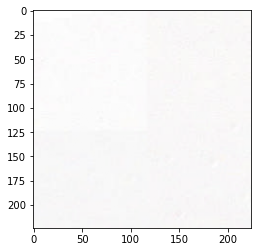

In [271]:
plt.imshow(test_images[0])

Enlist class presence in the first tile

In [272]:
putil.enlist_class_presence(test_masks[0])

array([0, 1], dtype=uint8)

Summarize distribution of classes in the first tile

In [273]:
putil.summarize_class_distribution(test_masks[0].numpy())

{0: 0.29, 1: 0.71}

In [274]:
test_images_raw, test_masks_raw = next(test_iter_raw)

Write basic U-Net model for semantic segmentation. The model will take as input the number of input channels (default = 3) and it will also take as input the number of classes, which is 6. The model will translate a tensor of shape [B, 3, H, W] to a tensor of shape [B, 6, H, W]. This will output a probability distribution over the six possible classes for each pixel in the image. 

In [235]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=6):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        def up_block(in_ch, out_ch):
            return nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_block(128, 64)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([up4, enc4], dim=1))
        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, enc3], dim=1))
        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))

        return self.final(dec1)

### Setup hyper-parameters for training of the model, including model instantiation, number of epochs, optimizer, and cross entropy loss function

In [236]:
# Instantiate the model
unet = UNet()

# Set number of epochs
num_epochs = 10

# Set up Adam optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# List to store the loss at each step (epoch and batch)
epoch_losses = []
batch_losses = []

# In order to print batches at a certain interval, specify the batch print interval
batch_print_interval = 10

# Specify a boolean for printing the loss in batch intervals
print_batch_loss = True

In [237]:
# Setup training loop for model on training dataset
for epoch in range(num_epochs):
    
    # Set epoch loss to zero
    epoch_loss = 0.0
    
    # Set unet model to training mode
    unet.train()
    
    # Loop over the batches of images and masks
    for batch_idx, (images, masks) in enumerate(train_loader):
        
        # permute the dimensions of the image
        # convert it from [B, H, W, C] to [B, C, H, W]
        reordered_images = images.permute(0, 3, 1, 2)
        
        # zero the gradients in the optimizer
        optimizer.zero_grad()
        
        # forward propagate the images through the model
        # the output should be of shape [B, num_classes, H, W]
        output = unet(reordered_images)
        
        # calculate the loss
        loss = loss_fn(output, masks.long())
        
        # Backpropagate to calculate gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Update the running total loss for the epoch
        epoch_loss += loss.item()
        
        # Append the loss to the list of batch losses
        batch_losses.append(loss.item())
        
        # Print batch loss
        if print_batch_loss and batch_idx % batch_print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}")
    
    # Append the average loss for the epoch to the loss list
    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    
    # Print the average loss at the end of the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_epoch_loss}")

Epoch [1/10], Batch [1/746], Loss: 1.6502048969268799
Epoch [1/10], Batch [11/746], Loss: 1.0249789953231812
Epoch [1/10], Batch [21/746], Loss: 0.8208789229393005
Epoch [1/10], Batch [31/746], Loss: 0.8018200993537903
Epoch [1/10], Batch [41/746], Loss: 0.9610015153884888
Epoch [1/10], Batch [51/746], Loss: 0.6269527077674866
Epoch [1/10], Batch [61/746], Loss: 0.6793991923332214
Epoch [1/10], Batch [71/746], Loss: 0.5831800699234009
Epoch [1/10], Batch [81/746], Loss: 0.6335410475730896
Epoch [1/10], Batch [91/746], Loss: 0.5936914682388306
Epoch [1/10], Batch [101/746], Loss: 0.4824484884738922
Epoch [1/10], Batch [111/746], Loss: 0.5929545760154724
Epoch [1/10], Batch [121/746], Loss: 0.6083338856697083
Epoch [1/10], Batch [131/746], Loss: 0.6746622323989868
Epoch [1/10], Batch [141/746], Loss: 0.5683163404464722
Epoch [1/10], Batch [151/746], Loss: 0.6526861190795898
Epoch [1/10], Batch [161/746], Loss: 0.43029534816741943
Epoch [1/10], Batch [171/746], Loss: 0.6034732460975647
Ep

Epoch [2/10], Batch [711/746], Loss: 0.6464621424674988
Epoch [2/10], Batch [721/746], Loss: 0.5628789663314819
Epoch [2/10], Batch [731/746], Loss: 0.5905479192733765
Epoch [2/10], Batch [741/746], Loss: 0.448097825050354
Epoch [2/10] Average Loss: 0.5595162517463553
Epoch [3/10], Batch [1/746], Loss: 0.6105414628982544
Epoch [3/10], Batch [11/746], Loss: 0.415192574262619
Epoch [3/10], Batch [21/746], Loss: 0.7155773639678955
Epoch [3/10], Batch [31/746], Loss: 0.748488187789917
Epoch [3/10], Batch [41/746], Loss: 0.4600714445114136
Epoch [3/10], Batch [51/746], Loss: 0.4349290132522583
Epoch [3/10], Batch [61/746], Loss: 0.3664478361606598
Epoch [3/10], Batch [71/746], Loss: 0.5839332938194275
Epoch [3/10], Batch [81/746], Loss: 0.48745056986808777
Epoch [3/10], Batch [91/746], Loss: 0.3844928741455078
Epoch [3/10], Batch [101/746], Loss: 0.4823852479457855
Epoch [3/10], Batch [111/746], Loss: 0.3894461393356323
Epoch [3/10], Batch [121/746], Loss: 0.564720869064331
Epoch [3/10], Ba

Epoch [4/10], Batch [661/746], Loss: 0.3941494822502136
Epoch [4/10], Batch [671/746], Loss: 0.5599123239517212
Epoch [4/10], Batch [681/746], Loss: 0.4620685577392578
Epoch [4/10], Batch [691/746], Loss: 0.47774356603622437
Epoch [4/10], Batch [701/746], Loss: 0.5500400066375732
Epoch [4/10], Batch [711/746], Loss: 0.9215179085731506
Epoch [4/10], Batch [721/746], Loss: 0.4031299948692322
Epoch [4/10], Batch [731/746], Loss: 0.3191789388656616
Epoch [4/10], Batch [741/746], Loss: 0.4236163794994354
Epoch [4/10] Average Loss: 0.49777317011164596
Epoch [5/10], Batch [1/746], Loss: 0.6572769284248352
Epoch [5/10], Batch [11/746], Loss: 0.694318950176239
Epoch [5/10], Batch [21/746], Loss: 0.5717067122459412
Epoch [5/10], Batch [31/746], Loss: 0.5537197589874268
Epoch [5/10], Batch [41/746], Loss: 0.3435181677341461
Epoch [5/10], Batch [51/746], Loss: 0.6655075550079346
Epoch [5/10], Batch [61/746], Loss: 0.4536544680595398
Epoch [5/10], Batch [71/746], Loss: 0.3979435861110687
Epoch [5/1

KeyboardInterrupt: 

Write function to predict mask from batch of input images

In [238]:
def draw_mask(image: np.ndarray, 
              mask: np.ndarray,
              color_rgb_list: List[int] = [0, 255, 0]):
    
    """
    Function to draw mask on an image based on the
    mask given (mask). The mask will be translucent
    green given the default color in color_rgb_list = [0, 225, 0]
    
    Parameters
    -----------
    image: np.ndarray
        The image over which the mask is to be overlayed
    
    mask: np.ndarray
        The mask that is to be overlayed on the image. 
        This mask must be boolean (containing only True or False)
        
    color_rgb_list: List[int]
        The RGB pixel configuration of the color of the translucent
        mask to overlay on the image. 
        Default = [0, 255, 0] (green)
    
    Returns
    ---------
    np.ndarray
        The image with the colored mask overlaid along the 
        pixel locations which indicate True in the mask. 
    
    """
    
    masked_image = image.copy()
    masked_image = np.where(mask.astype(int),
                            np.array(color_rgb_list, dtype='uint8'),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [239]:
def apply_segment_to_image_by_label(image,
                                    mask,
                                    label_id,
                                    color_lst):
    
    """
    Function to apply segmentation mask to image
    for a specific label_id
    
    Parameters
    -----------
    image: np.ndarray
        The image to which the segmentation mask is to
        be applied for that specific label_id
    
    mask: np.ndarray
        The mask which is to be applied to the image
        where the label_id is present
    
    label_id: int
        The label_id that is to be applied to the
        image from the segmentation mask
    
    color_lst: List[int]
        The color, expressed as list of RGB integer values,
        to be applied to the image where the label_id is
        present in the corresponding segmentation mask
    
    Returns
    --------
    np.ndarray
        The image with the segmentation mask applied
        at the pixel locations where label_id is present
        
    """
    
    avail_labels = list(putil.enlist_class_presence(mask))
    #assert label_id in avail_labels
    
    assert image.shape == mask.shape
    assert image.shape[-1] == 3 and mask.shape[-1] == 3
    
    assert np.sum(mask[:,:,1]) == 0 and np.sum(mask[:,:,2]) == 0
    
    if np.sum(mask[:,:,0]) == 0:
        print("The image is all background")
    
    reduced_mask = mask[:, :, 0]
    assert len(reduced_mask.shape) == 2
    
    assert set(list(np.unique(reduced_mask))) == set(avail_labels)
    
    boolean_label_mask = reduced_mask == label_id
    assert (reduced_mask == label_id).sum() == boolean_label_mask.sum()
    
    n_on_bits_for_label = (reduced_mask == label_id).sum()
    
    boolean_label_mask_3d = np.repeat(boolean_label_mask[:, :, np.newaxis], 3, axis=2)
    
    for i in range(3):
        assert np.sum(boolean_label_mask_3d[:, :, i]) == n_on_bits_for_label
        
    segmented_image = draw_mask(image, boolean_label_mask_3d, color_rgb_list = color_lst)
    
    return segmented_image

In [240]:
def apply_segment_to_image_by_multiple_labels(image: np.ndarray,
                                              mask: np.ndarray,
                                              label_ids: List[int],
                                              color_rgb_pixels: List[list[int,int,int]] = [[0, 255, 0],
                                                                                           [255, 0, 0],
                                                                                           [0, 0, 255],
                                                                                           [255, 255, 0],
                                                                                           [255, 0, 255],
                                                                                           [0, 255, 255],
                                                                                           [255, 165, 0],
                                                                                           [128, 0, 128]],
                                              colors: List[str] = ["green",
                                                                    "red",
                                                                    "blue",
                                                                    "yellow",
                                                                    "magenta",
                                                                     "cyan",
                                                                    "orange",
                                                                     "purple"],
                                              
                                              id_to_class: Dict[int, str] = {0:"background (non tissue) or unknown",
                                                                             1:"stroma (connective tissue, non-epithelium tissue)",
                                                                             2: "healthy (benign) epithelium",
                                                                             3: "cancerous epithelium (Gleason 3)",
                                                                             4: "cancerous epithelium (Gleason 4)",
                                                                             5: "cancerous epithelium (Gleason 5)"},
                                               print_color: bool = False) -> np.ndarray:
    
    for i in range(len(label_ids)):
        image = apply_segment_to_image_by_label(image = image,
                                                mask = mask,
                                                label_id = label_ids[i],
                                                color_lst = color_rgb_pixels[i])
        if print_color:
            print(f"{colors[i]} : {id_to_class[label_ids[i]]}")
    
    return image

In [241]:
def predict_mask(model, images):
    model.eval()
    with torch.no_grad():
        images = images.permute(0, 3, 1, 2)
        output = model(images)
        pred_mask = torch.argmax(output, dim = 1)
    return pred_mask

In [275]:
test_pred_mask = predict_mask(model = unet,
                              images = test_images)

In [276]:
test_images.shape

torch.Size([24, 224, 224, 3])

In [277]:
test_images_raw.shape

torch.Size([24, 224, 224, 3])

In [278]:
test_pred_mask.shape

torch.Size([24, 224, 224])

In [279]:
test_masks.shape

torch.Size([24, 224, 224])

In [280]:
def plot_gt_pred_image(image,
                       gt_mask,
                       pred_mask,
                       tile_size = 224):
    
    processed_gt_mask = np.zeros((tile_size, tile_size, 3))
    processed_gt_mask[:, :, 0] = gt_mask
    gt_label_ids = list(putil.enlist_class_presence(gt_mask))
    gt_segmented_image = apply_segment_to_image_by_multiple_labels(image = image,
                                                                   mask = processed_gt_mask,
                                                                   label_ids = gt_label_ids,
                                                                   print_color = True)
    print("\n")
    
    processed_pred_mask = np.zeros((tile_size, tile_size, 3))
    processed_pred_mask[:, :, 0] = pred_mask
    pred_label_ids = list(putil.enlist_class_presence(pred_mask))
    pred_segmented_image = apply_segment_to_image_by_multiple_labels(image = image,
                                                                     mask = processed_pred_mask,
                                                                     label_ids = pred_label_ids,
                                                                     print_color = True)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(image)
    ax[0].set_title('Original Image')  
    ax[0].axis('off')  

    ax[1].imshow(gt_segmented_image)
    ax[1].set_title(f'Ground Truth Segmented Image')  
    ax[1].axis('off')  

    ax[2].imshow(pred_segmented_image)
    ax[2].set_title(f'U-Net Segmented Image')  
    ax[2].axis('off')  


    plt.tight_layout()

    plt.show()

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


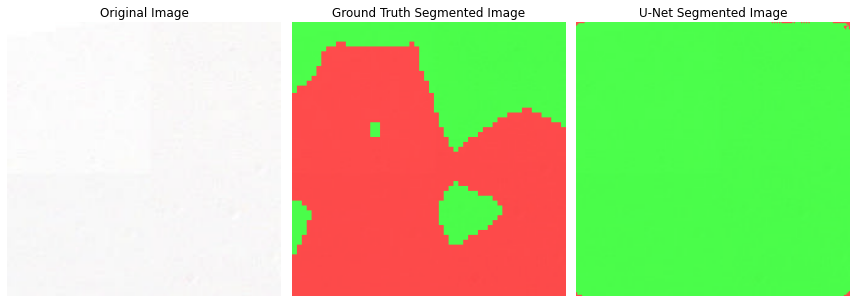

In [285]:
sample_id = 0

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


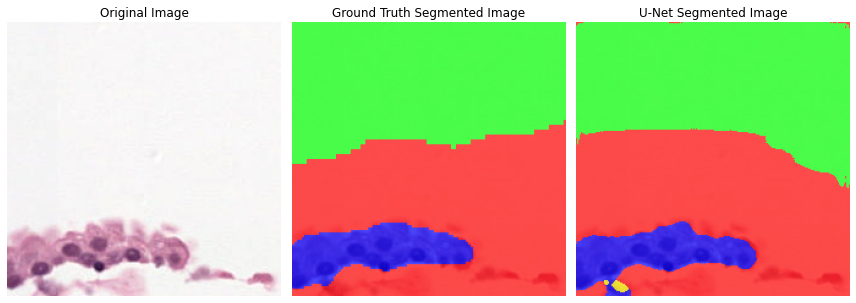

In [286]:
sample_id = 1

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


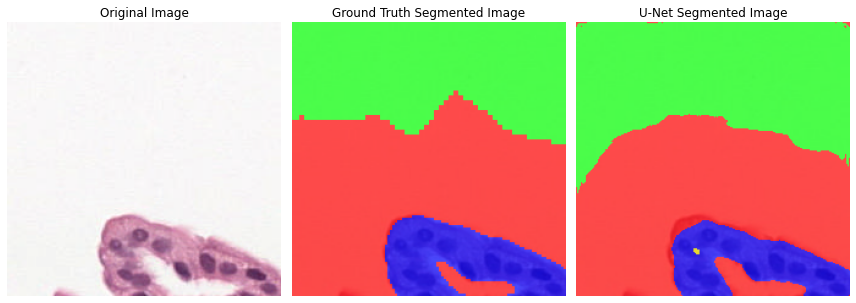

In [287]:
sample_id = 2

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)


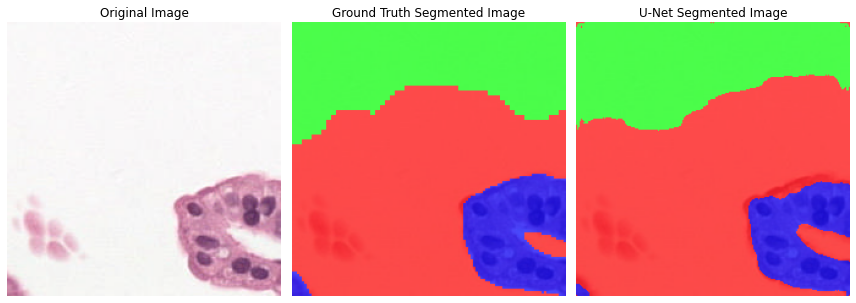

In [288]:
sample_id = 3

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


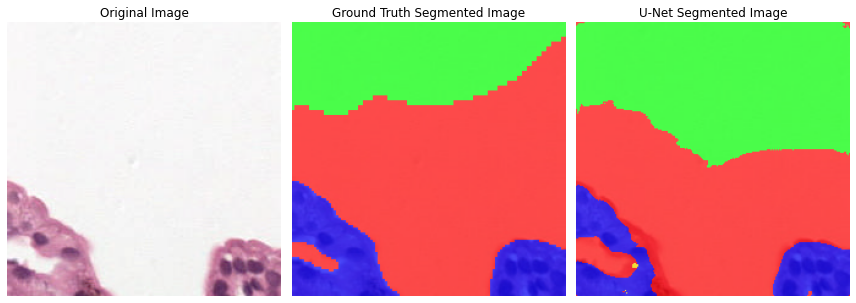

In [289]:
sample_id = 4

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


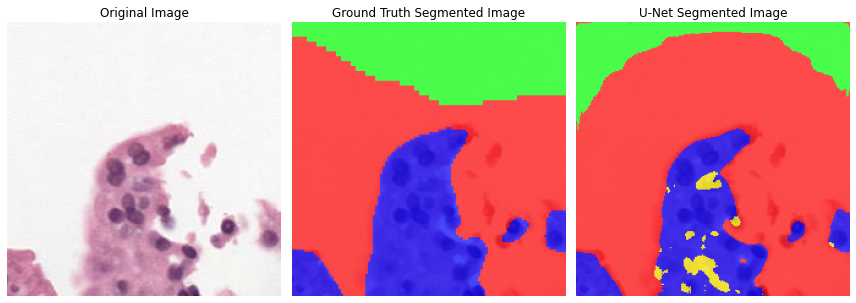

In [290]:
sample_id = 5

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


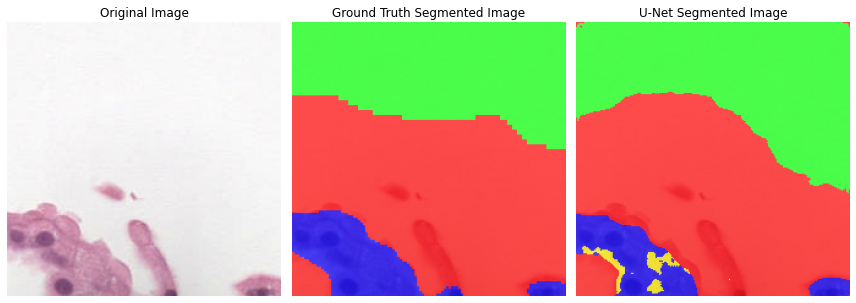

In [291]:
sample_id = 6

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


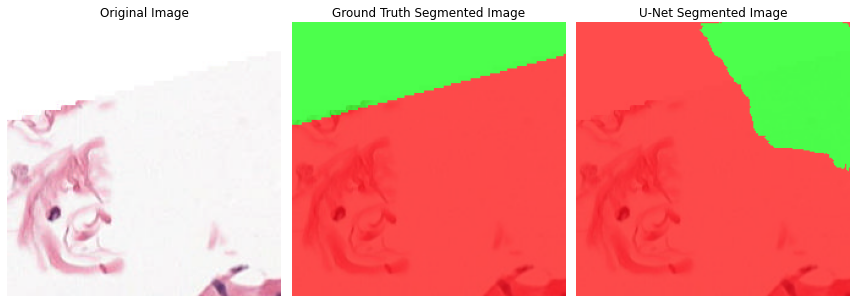

In [292]:
sample_id = 7

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


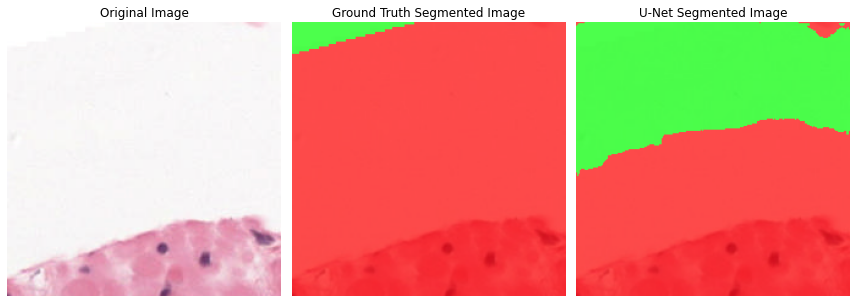

In [293]:
sample_id = 8

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


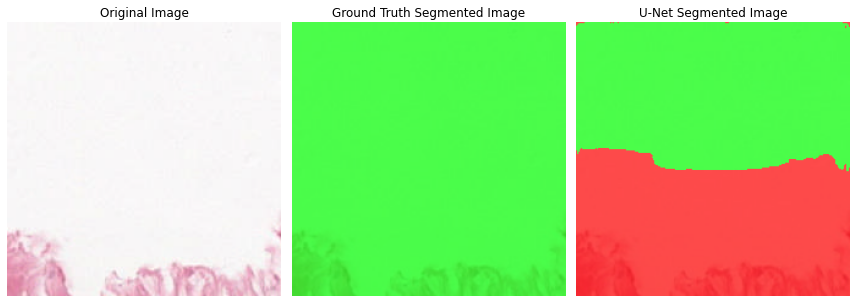

In [294]:
sample_id = 9

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


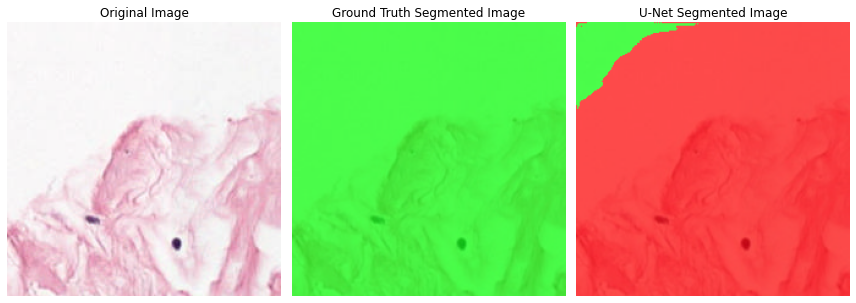

In [295]:
sample_id = 10

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)


green : stroma (connective tissue, non-epithelium tissue)


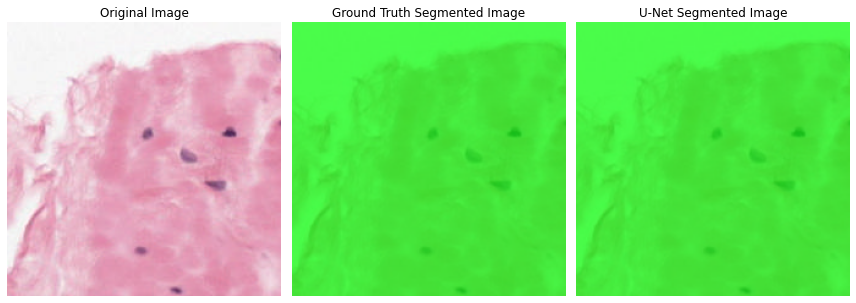

In [296]:
sample_id = 11

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


green : stroma (connective tissue, non-epithelium tissue)


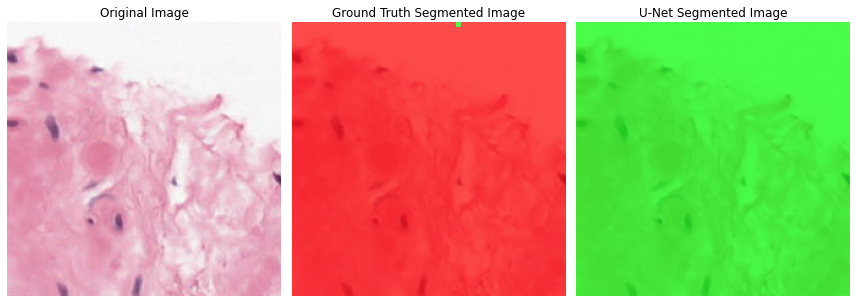

In [297]:
sample_id = 12

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)


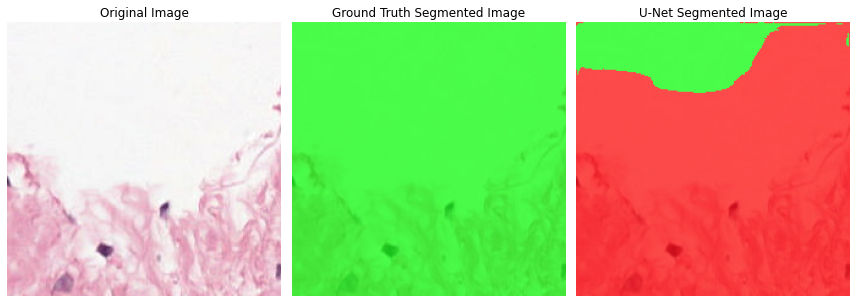

In [298]:
sample_id = 13

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : healthy (benign) epithelium


green : stroma (connective tissue, non-epithelium tissue)


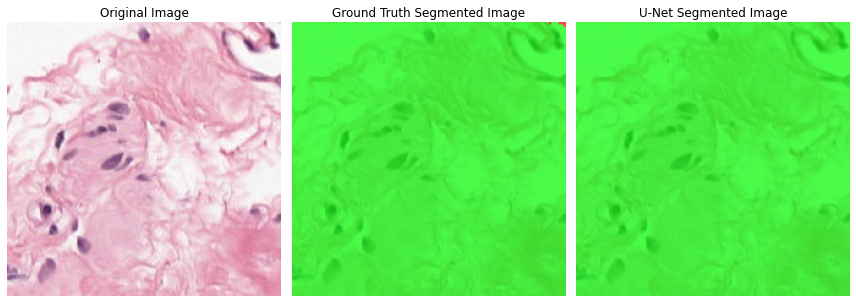

In [299]:
sample_id = 14

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : healthy (benign) epithelium


green : stroma (connective tissue, non-epithelium tissue)


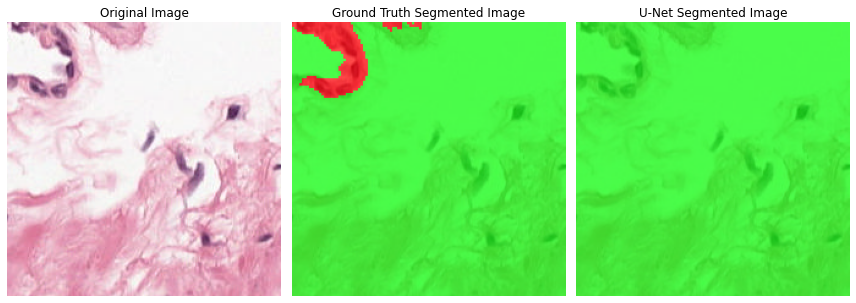

In [300]:
sample_id = 15

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)


green : stroma (connective tissue, non-epithelium tissue)


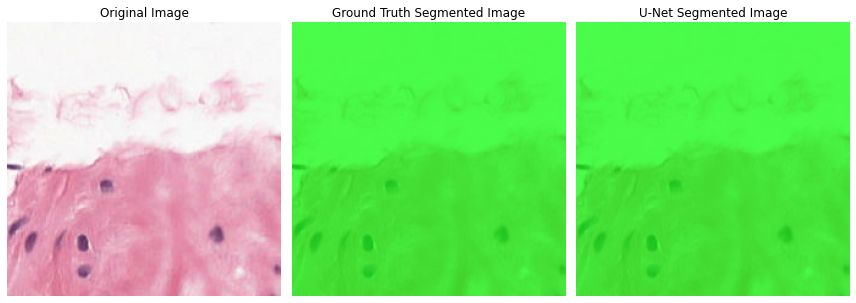

In [301]:
sample_id = 16

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : healthy (benign) epithelium


green : stroma (connective tissue, non-epithelium tissue)


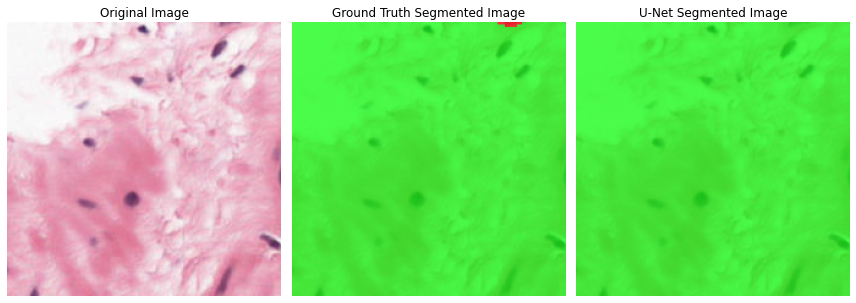

In [302]:
sample_id = 17

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : healthy (benign) epithelium
yellow : cancerous epithelium (Gleason 4)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


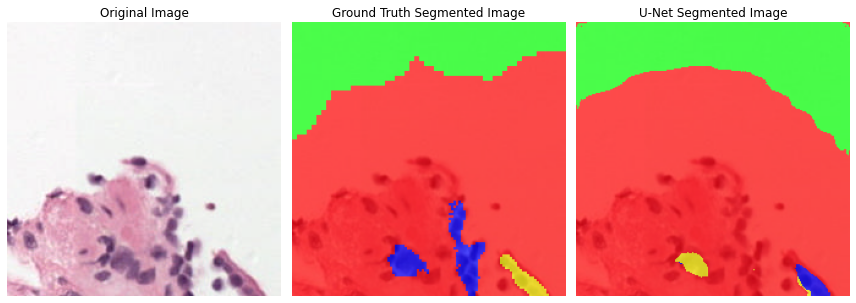

In [303]:
sample_id = 18

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


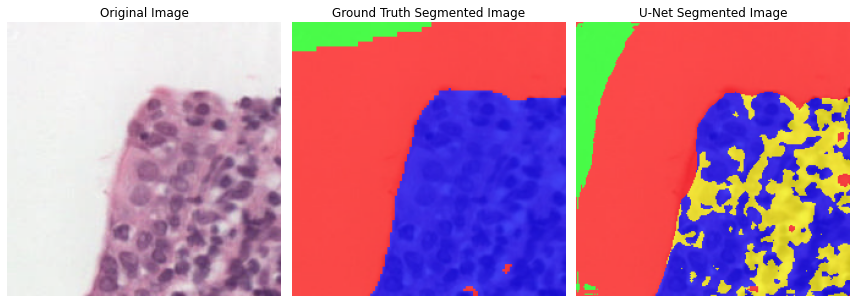

In [304]:
sample_id = 19

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 4)


green : stroma (connective tissue, non-epithelium tissue)
red : healthy (benign) epithelium
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


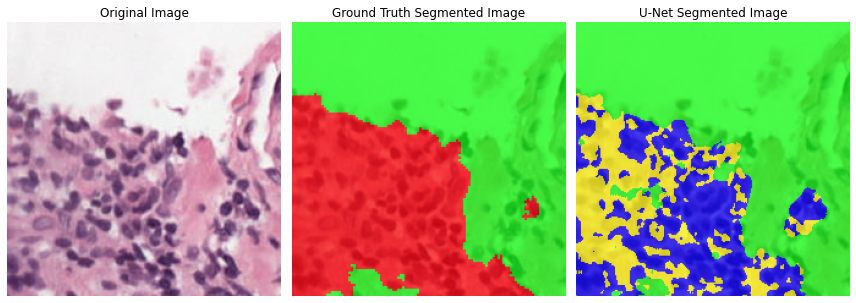

In [305]:
sample_id = 20

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 3)
blue : cancerous epithelium (Gleason 4)


green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 4)
blue : cancerous epithelium (Gleason 5)


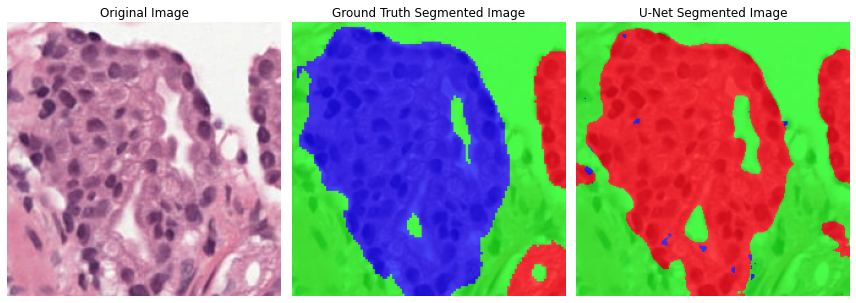

In [306]:
sample_id = 21

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 3)


green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 4)
blue : cancerous epithelium (Gleason 5)


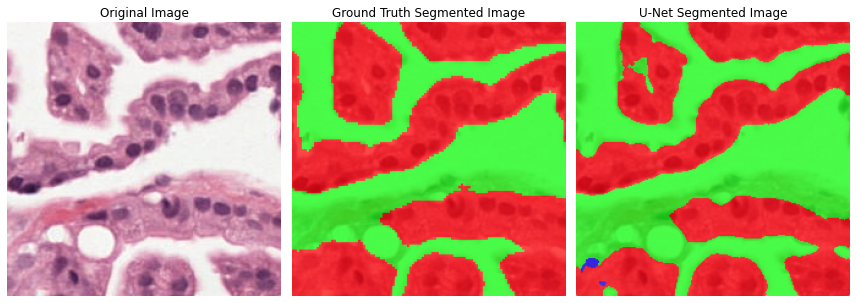

In [307]:
sample_id = 22

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())

green : stroma (connective tissue, non-epithelium tissue)
red : cancerous epithelium (Gleason 3)


green : background (non tissue) or unknown
red : stroma (connective tissue, non-epithelium tissue)
blue : cancerous epithelium (Gleason 4)
yellow : cancerous epithelium (Gleason 5)


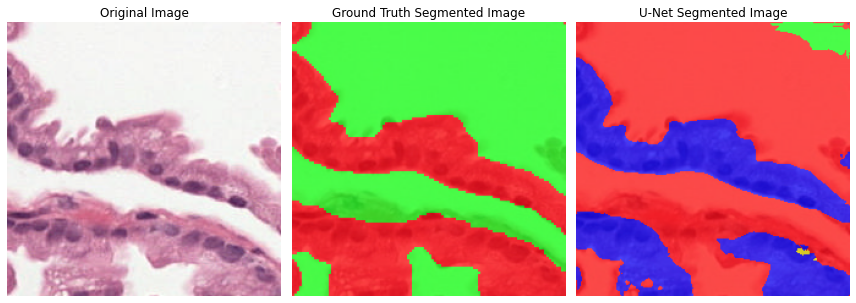

In [308]:
sample_id = 23

plot_gt_pred_image(image = test_images_raw[sample_id].numpy(),
                   gt_mask = test_masks[sample_id].numpy(),
                   pred_mask = test_pred_mask[sample_id].numpy())